Krzysztof Sołowiej

krsolowiej@gmail.com


# Training, testing and using image segmentation model with TensorFlow


The project is an implementation of the Mask R-CNN algorithm aimed to detect and segment rectangular shapes in paintings of Mark Rothko.

The training set consisted of 128 and the validation set of 22 different images with coco style annotations in JSON format.

The training process was stopped after seven epochs consisting of 128 steps.
The resulting model detects two classes of objects:
1) 'rectangle' - a large rectangle with a distinctive color
2) 'band' - a horizontal strip of distinctive color

By using segmentation, the following properties of the detected region can be calculated:
- Class
- Average color
- Brightness of color (bright/dull)
- Max horizontal pixels
- Max vertical pixels
- Region surface
- Percentage share in the area of the whole image

Resources:

https://github.com/ahmedfgad/Mask-RCNN-TF2

https://github.com/bnsreenu/python_for_microscopists/blob/master/286-Object%20detection%20using%20mask%20RCNN%20-%20end%20to%20end/286-marbles_maskrcnn_coco_style_labels.py

In [1]:
import os
import sys
import csv
import json
import datetime
import numpy as np
import skimage.draw
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config

In [3]:
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


In [4]:
from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw

# Dataset preparation

In [5]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids


In [6]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/train/train.json', 'C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/train')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/test/test.json', 'C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/test')
dataset_val.prepare()

In [7]:
dataset = dataset_train
image_ids = dataset.image_ids
image_ids = np.random.choice(dataset.image_ids, 3)
#for image_id in image_ids:
#    image = dataset.load_image(image_id)
#    mask, class_ids = dataset.load_mask(image_id)
#    display_top_masks(image, mask, class_ids, dataset.class_names, limit=2)

# Showing single image with annotations

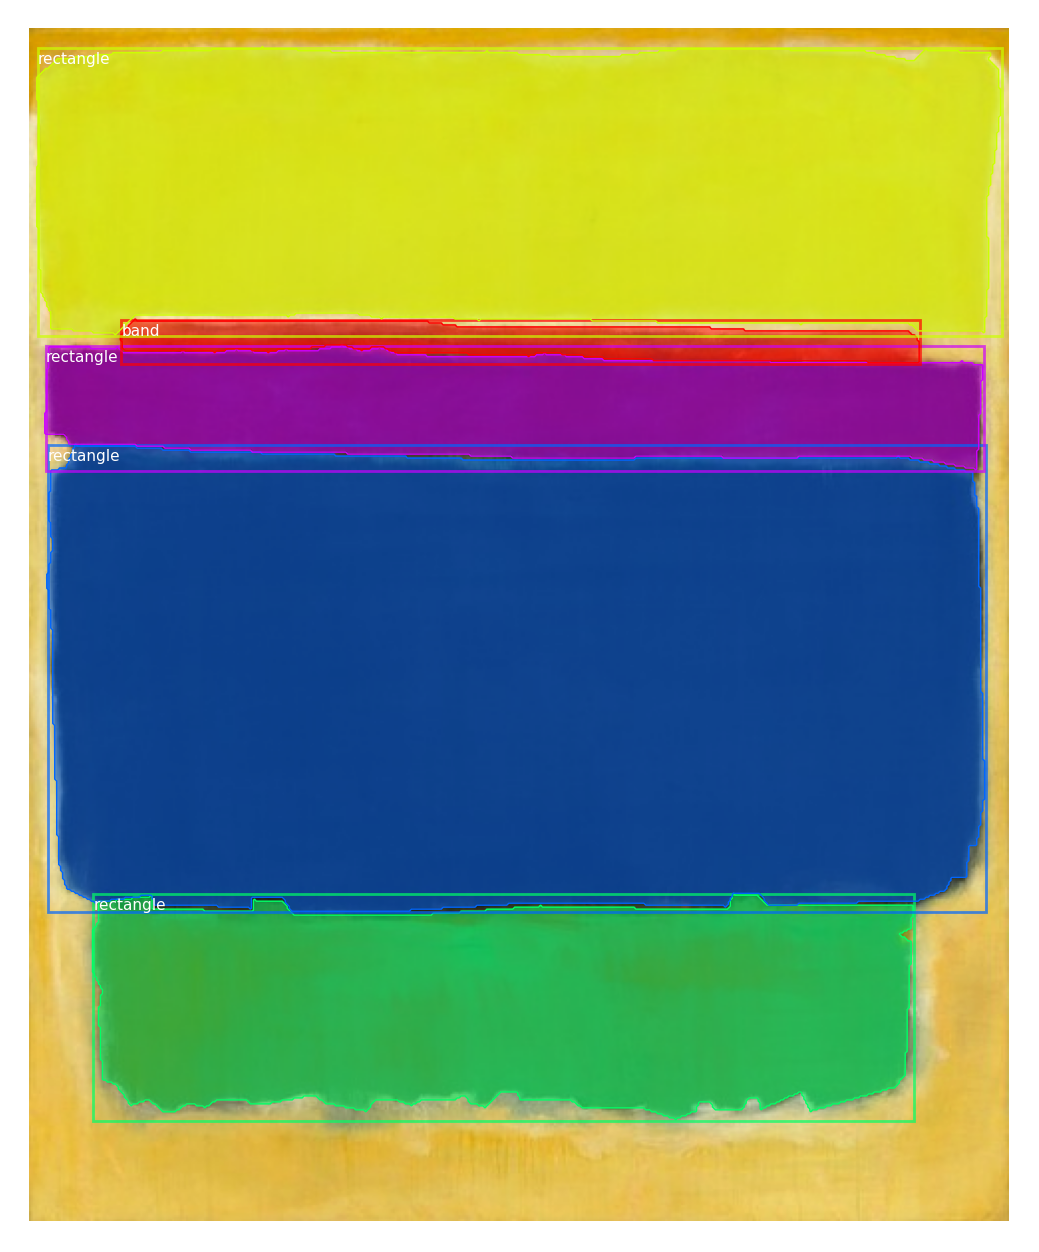

In [8]:
# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

# Training

In [9]:
# define a configuration for the model
class RothkoConfig(Config):
	# define the name of the configuration
	NAME = "rothko_cfg_coco"
	# number of classes (background + class 1 + class 2)
	NUM_CLASSES = 1 + 2
	# number of training steps per epoch
	STEPS_PER_EPOCH = 128
    #DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
# prepare config
config = RothkoConfig()
config.display() 


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [10]:
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [11]:
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# For training uncomment the following line
#model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=20, layers='heads')

# Testing trained model

In [12]:
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle


# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "rothko_cfg_coco"
	# number of classes (background + 2 classes)
	NUM_CLASSES = 1 + 2
	# Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
 

In [13]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the Mean Average Precision across all images
	mAP = mean(APs)
	return mAP
 

In [14]:
# create config
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)

# load model weights
model.load_weights('C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/logs/mask_rcnn_rothko_cfg_coco_0007.h5', by_name=True)

# evaluate model on training dataset
#train_mAP = evaluate_model(dataset_train, model, cfg)
#print("Train mAP (Mean Average Precision): %.3f" % train_mAP)

# evaluate model on test dataset
test_mAP = evaluate_model(dataset_train, model, cfg)
print("Test mAP (Mean Average Precision): %.3f" % test_mAP)

Test mAP (Mean Average Precision): 0.805


# Using trained model

In [15]:
def analyze_image(image_path, threshold=0.94):

    sample_img = skimage.io.imread(image_path)
    plt.imshow(sample_img)
    plt.axis('off')

    # Detect objects in the image
    detected = model.detect([sample_img])
    results = detected[0]

    # Get the number of detected shapes
    num_shapes = len(results['class_ids'])
    print("Number of detected shapes:", num_shapes)

    # Set the threshold for displayed objects and color analysis
    threshold = threshold
    print('Detection score threshold: ', threshold)

    # Get the indices of objects with scores greater than or equal to the threshold
    idxs = np.where(results['scores'] >= threshold)[0]

    # Extract the relevant results for the displayed objects
    rois = results['rois'][idxs]
    masks = results['masks'][:,:,idxs]
    class_ids = results['class_ids'][idxs]
    scores = results['scores'][idxs]

    # Count the number of displayed shapes
    num_displayed_shapes = len(class_ids)
    print("Number of displayed shapes above set threshold:", num_displayed_shapes)

    # Calculate the total number of pixels in the image
    total_pixels = sample_img.shape[0] * sample_img.shape[1]

    # Display the image with the detected shapes
    class_names = ['BG', 'Rectangle', 'Band']
    display_instances(sample_img, rois, masks, class_ids, class_names, scores)

    # Get the indices of objects with scores greater than or equal to the threshold
    idxs = np.where(results['scores'] >= threshold)[0]

    # Extract the relevant masks for the displayed objects
    masks = results.get('masks')[:,:,idxs]

    # Define a function to check if a color is bright or dull
    def is_bright(rgb):
        brightness = np.sqrt(np.dot(rgb, rgb))
        return brightness > 128

    # Extract the pixels and colors of the displayed regions
    region_pixels = []
    region_colors = []
    for i in range(masks.shape[2]):
        mask = masks[:,:,i]
        pixels = sample_img[mask]
        colors = np.mean(pixels, axis=0)
        height, width = mask.shape
        region_pixels.append(pixels)
        region_colors.append(colors)
    
        # Calculate the maximum horizontal and vertical pixels
        max_horizontal_pixels = np.max(np.sum(mask, axis=0))
        max_vertical_pixels = np.max(np.sum(mask, axis=1))
    
        # Calculate the percentage surface of the region in relation to the whole image
        region_surface = np.round((np.sum(mask) / total_pixels * 100), 1)
    
        # Loop over each region to display its color information
        for i in range(len(region_colors)):
            rgb = region_colors[i]
        if is_bright(rgb):
            brightness = "bright"
        else:
            brightness = "dull"

        # Create a figure with subplots for the color rectangle and histogram
        fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

        # Add the color rectangle subplot
        color_rect = np.array([colors])
        axs[0].imshow(color_rect.reshape(1, 1, 3)/255.0)
        axs[0].set_title('Average Color')
        axs[0].axis('off')

        # Add the histogram subplot
        axs[1].hist(pixels[:, 0], bins=256, color='Red', alpha=0.5, label='Red')
        axs[1].hist(pixels[:, 1], bins=256, color='Green', alpha=0.5, label='Green')
        axs[1].hist(pixels[:, 2], bins=256, color='Blue', alpha=0.5, label='Blue')
        axs[1].legend(loc='upper right')
        axs[1].set_xlim([0, 255])
        axs[1].set_xlabel('Color Value')
        axs[1].set_ylabel('Frequency')
        axs[1].set_title('Histogram')
        plt.suptitle('Region {} - Class: {} - Score: {:.2f} - Color {}: ({:.2f}, {:.2f}, {:.2f}) - Max Horizontal Pixels: {} - Max Vertical Pixels: {} - Region surface: {}%'.format(
                    i+1, class_names[results.get('class_ids')[idxs[i]]], results.get('scores')[idxs[i]], brightness,
                    region_colors[i][0], region_colors[i][1], region_colors[i][2], 
                    max_horizontal_pixels, max_vertical_pixels, region_surface))

        plt.show()

Number of detected shapes: 3
Detection score threshold:  0.85
Number of displayed shapes above set threshold: 3


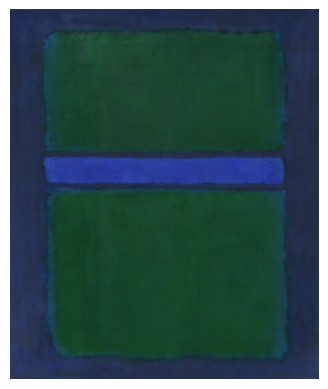

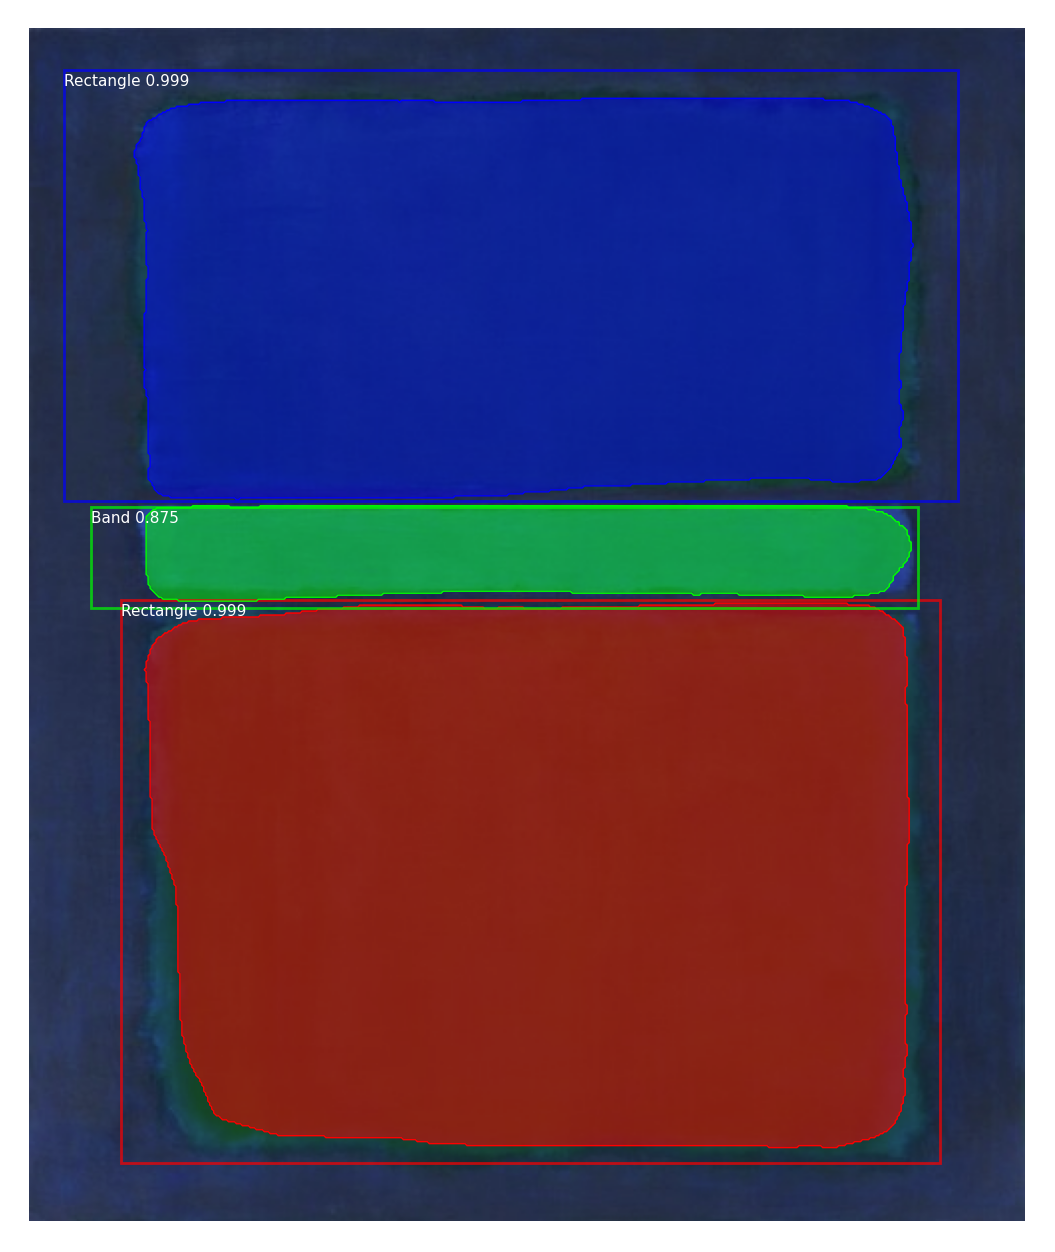

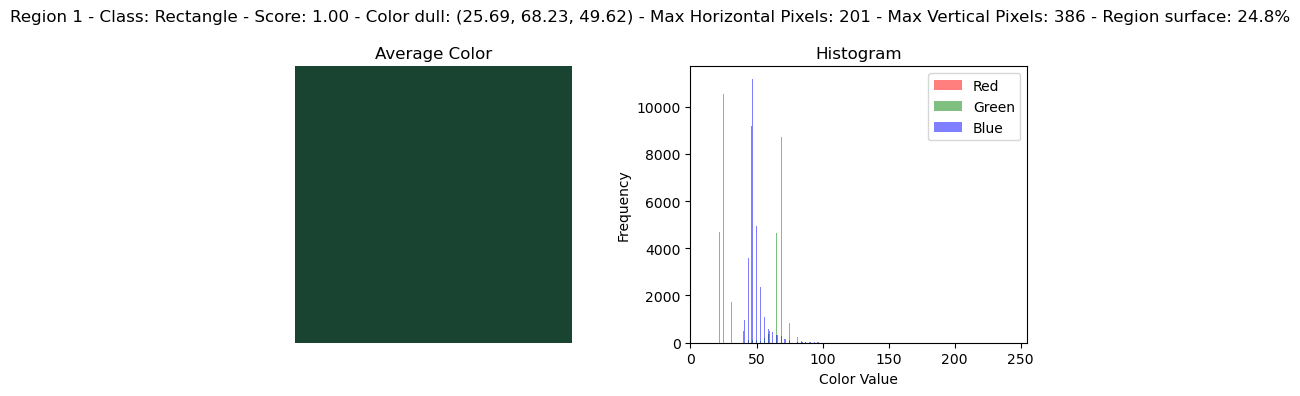

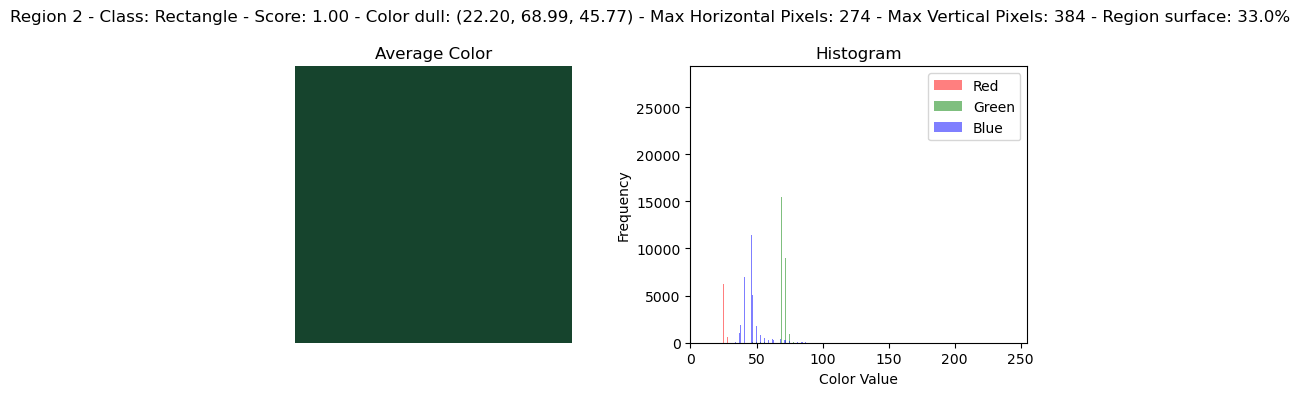

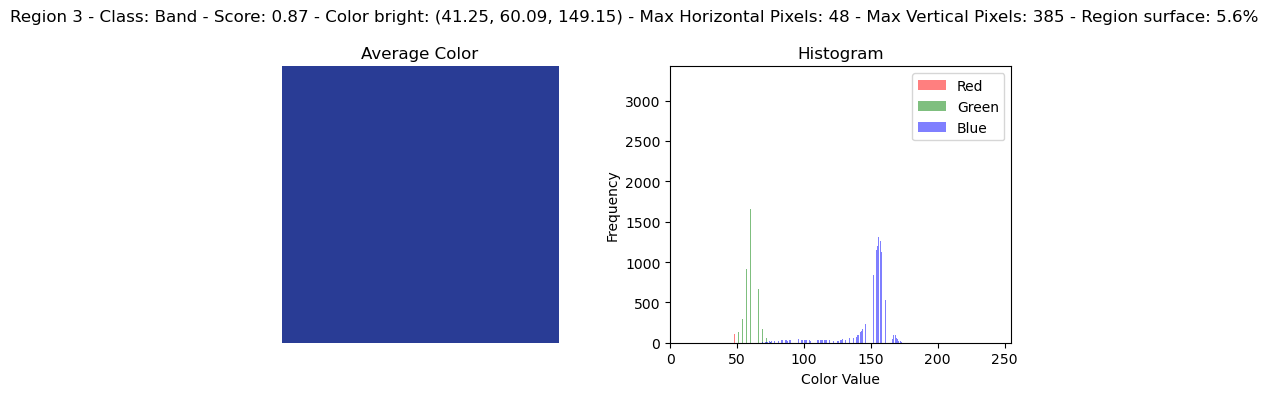

In [16]:
path = "C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/small_data/582.png"

analyze_image(path, threshold=0.85)

# Preparing data in csv format for small sample of images

In [17]:
def write_data(image_path, threshold=0.94, mode='w'):
    file_exists = os.path.exists('C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/data.csv')
    with open('C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/data.csv', mode=mode, newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['image', 'num_of_detected_shapes', 'thresh', 'num_of_displayed_shapes', 'region', 'class', 'score', 'color', 'r', 'g', 'b', 'max_horizontal_pixels', 'max_vertical_pixels', 'region_surface'])

        sample_img = skimage.io.imread(image_path)
        detected = model.detect([sample_img])
        results = detected[0]

        num_shapes = len(results['class_ids'])

        threshold = threshold
        class_names = ['BG', 'Rectangle', 'Band']
        idxs = np.where(results['scores'] >= threshold)[0]

        rois = results['rois'][idxs]
        masks = results['masks'][:,:,idxs]
        class_ids = results['class_ids'][idxs]
        scores = results['scores'][idxs]

        num_displayed_shapes = len(class_ids)

        total_pixels = sample_img.shape[0] * sample_img.shape[1]

        idxs = np.where(results['scores'] >= threshold)[0]

        masks = results.get('masks')[:,:,idxs]

        def is_bright(rgb):
            brightness = np.sqrt(np.dot(rgb, rgb))
            return brightness > 128

        region_pixels = []
        region_colors = []
        
        for i in range(masks.shape[2]):
            mask = masks[:,:,i]
            pixels = sample_img[mask]
            colors = np.mean(pixels, axis=0)
            height, width = mask.shape
            region_pixels.append(pixels)
            region_colors.append(colors)

            max_horizontal_pixels = np.max(np.sum(mask, axis=0))
            max_vertical_pixels = np.max(np.sum(mask, axis=1))

            region_surface = np.round((np.sum(mask) / total_pixels * 100), 1)

            for i in range(len(region_colors)):
                rgb = region_colors[i]
                if is_bright(rgb):
                    brightness = "bright"
                else:
                    brightness = "dull"

            writer.writerow([
                os.path.splitext(os.path.basename(image_path))[0],
                num_shapes,
                threshold,
                num_displayed_shapes,
                i+1, 
                class_names[results.get('class_ids')[idxs[i]]], 
                results.get('scores')[idxs[i]], 
                brightness,
                region_colors[i][0], 
                region_colors[i][1], 
                region_colors[i][2], 
                max_horizontal_pixels, 
                max_vertical_pixels, 
                region_surface
            ])


In [18]:
image_path = 'C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/small_data/741.png'

#write_data(image_path, threshold=0.96, mode='w')

In [19]:
folder_path = 'C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/small_data'

#for filename in os.listdir(folder_path):
#    if filename.endswith('.png'):
#        image_path = os.path.join(folder_path, filename)
#        write_data(image_path, threshold=0.96, mode='a')

In [20]:
data = pd.read_csv('rothko/data.csv')
df_1 = pd.DataFrame(data)
df_1

,image,num_of_detected_shapes,thresh,num_of_displayed_shapes,region,class,score,color,r,g,b,max_horizontal_pixels,max_vertical_pixels,region_surface
0,525,5,0.96,3,1,Rectangle,0.999673,bright,227.632276,125.604287,50.607011,307,453,40.0
1,525,5,0.96,3,2,Rectangle,0.999564,bright,216.347172,136.520151,56.226160,213,436,26.0
2,525,5,0.96,3,3,Band,0.980370,bright,217.708932,184.831679,96.191902,39,413,3.7
3,530,5,0.96,2,1,Rectangle,0.999144,bright,174.180793,116.361249,7.603447,272,468,41.3
4,530,5,0.96,2,2,Rectangle,0.998943,bright,169.943981,50.767856,24.768737,195,458,29.0
5,582,3,0.96,2,1,Rectangle,0.999167,dull,25.685121,68.229780,49.620245,201,386,24.8
6,582,3,0.96,2,2,Rectangle,0.998529,dull,22.199455,68.992345,45.765892,274,384,33.0
7,648,3,0.96,1,1,Rectangle,0.987087,bright,140.176329,33.020781,34.421863,368,266,66.9
8,655,1,0.96,1,1,Rectangle,0.999615,dull,97.890813,54.205484,50.791856,320,451,64.1
9,733,6,0.96,3,1,Rectangle,0.996595,bright,138.410219,88.529381,38.620274,1428,1174,76.7


In [29]:
database = pd.read_csv('rothko/database.csv', sep=';')
df_2 = pd.DataFrame(database)
df_2

,image,name,year,height,weight,collection,link
0,525,"UNTITLED {YELLOW, ORANGE,YELLOW,LIGHT ORANGE}",1955,207.0,152.5,"Collection of Mrs. Paul Mellon, Upperville, Va.",https://i.imgur.com/McucdCo.png
1,530,RED BAND {UNTITLED},1955,204.2,171.7,"National Gallery of Art, Washington",https://i.imgur.com/tInRmNC.png
2,582,UNTITLED,1957,247.3,207.8,"National Gallery of Art, Washington",https://i.imgur.com/B3YMygp.png
3,648,UNTITLED {SEAGRAM MURAL SKETCH},1959,266.1,215.9,Collection of Christopher Rothko,https://i.imgur.com/ZuCBNG9.png
4,655,UNTITLED {SEAGRAM MURAL SECTION},1959,269.0,457.8,"National Gallery of Art, Washington",https://i.imgur.com/3J6TZTk.png
5,733,No. 213 [?] [HARVARD MURAL SKETCH],1962,175.3,152.7,Collection of Christopher Rothko,https://i.imgur.com/wsw6Uup.png
6,741,PANEL FIVE [HARVARD MURAL],1962,266.7,297.2,"Fogg Art Museum, Harvard University Art Museum",https://i.imgur.com/o5EQVI3.png
7,752,"No. 202 (ORANGE, BROWN)",1963,228.6,175.3,The Detroit Institute of Art,https://i.imgur.com/qgj7LxS.png
8,779,No. 6[?] {BLACK ON BLACK},1964,236.2,193.0,"National Gallery of Art, Washington",https://i.imgur.com/lkuDvp2.png
9,834,UNTITLED,1970,152.4,145.1,"National Gallery of Art, Washington",https://i.imgur.com/heZzv9I.png


In [30]:
full_df = df_1.merge(df_2, on='image')
full_df

,image,num_of_detected_shapes,thresh,num_of_displayed_shapes,region,class,score,color,r,g,b,max_horizontal_pixels,max_vertical_pixels,region_surface,name,year,height,weight,collection,link
0,525,5,0.96,3,1,Rectangle,0.999673,bright,227.632276,125.604287,50.607011,307,453,40.0,"UNTITLED {YELLOW, ORANGE,YELLOW,LIGHT ORANGE}",1955,207.0,152.5,"Collection of Mrs. Paul Mellon, Upperville, Va.",https://i.imgur.com/McucdCo.png
1,525,5,0.96,3,2,Rectangle,0.999564,bright,216.347172,136.520151,56.226160,213,436,26.0,"UNTITLED {YELLOW, ORANGE,YELLOW,LIGHT ORANGE}",1955,207.0,152.5,"Collection of Mrs. Paul Mellon, Upperville, Va.",https://i.imgur.com/McucdCo.png
2,525,5,0.96,3,3,Band,0.980370,bright,217.708932,184.831679,96.191902,39,413,3.7,"UNTITLED {YELLOW, ORANGE,YELLOW,LIGHT ORANGE}",1955,207.0,152.5,"Collection of Mrs. Paul Mellon, Upperville, Va.",https://i.imgur.com/McucdCo.png
3,530,5,0.96,2,1,Rectangle,0.999144,bright,174.180793,116.361249,7.603447,272,468,41.3,RED BAND {UNTITLED},1955,204.2,171.7,"National Gallery of Art, Washington",https://i.imgur.com/tInRmNC.png
4,530,5,0.96,2,2,Rectangle,0.998943,bright,169.943981,50.767856,24.768737,195,458,29.0,RED BAND {UNTITLED},1955,204.2,171.7,"National Gallery of Art, Washington",https://i.imgur.com/tInRmNC.png
5,582,3,0.96,2,1,Rectangle,0.999167,dull,25.685121,68.229780,49.620245,201,386,24.8,UNTITLED,1957,247.3,207.8,"National Gallery of Art, Washington",https://i.imgur.com/B3YMygp.png
6,582,3,0.96,2,2,Rectangle,0.998529,dull,22.199455,68.992345,45.765892,274,384,33.0,UNTITLED,1957,247.3,207.8,"National Gallery of Art, Washington",https://i.imgur.com/B3YMygp.png
7,648,3,0.96,1,1,Rectangle,0.987087,bright,140.176329,33.020781,34.421863,368,266,66.9,UNTITLED {SEAGRAM MURAL SKETCH},1959,266.1,215.9,Collection of Christopher Rothko,https://i.imgur.com/ZuCBNG9.png
8,655,1,0.96,1,1,Rectangle,0.999615,dull,97.890813,54.205484,50.791856,320,451,64.1,UNTITLED {SEAGRAM MURAL SECTION},1959,269.0,457.8,"National Gallery of Art, Washington",https://i.imgur.com/3J6TZTk.png
9,733,6,0.96,3,1,Rectangle,0.996595,bright,138.410219,88.529381,38.620274,1428,1174,76.7,No. 213 [?] [HARVARD MURAL SKETCH],1962,175.3,152.7,Collection of Christopher Rothko,https://i.imgur.com/wsw6Uup.png


In [31]:
full_df.shape

(21, 20)

In [32]:
full_df.dtypes

image                        int64
num_of_detected_shapes       int64
thresh                     float64
num_of_displayed_shapes      int64
region                       int64
class                       object
score                      float64
color                       object
r                          float64
g                          float64
b                          float64
max_horizontal_pixels        int64
max_vertical_pixels          int64
region_surface             float64
name                        object
year                         int64
height                     float64
weight                     float64
collection                  object
link                        object
dtype: object